In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import os
import glob
import xarray as xr
from sklearn import preprocessing
import netCDF4 as nc
import matplotlib.pyplot as plt



np.random.seed(14)  # For reproducibility
torch.manual_seed(14)  # For reproducibility

# Dataloader

### Create input and output channels

In [2]:
# function that splits datasets along the spacial axes and concats them back into single array under time

def normalize(data):
    #normalized_data =  (data - data.mean(skipna=True).values)/data.std(skipna=True).values
    normalized_data = (data - np.mean(data))/np.std(data)
    return normalized_data


def load_norm_data(var_name_string):
    PATH_LIST = glob.glob(BASE+'*/preprocessed_data/'+var_name_string+'.nc') 
    data_app = normalize(xr.open_dataarray(PATH_LIST[0]).to_numpy()[:,4:-4,4:-4])
    for i_file in np.arange(1,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH).to_numpy()[:,4:-4,4:-4]
        data_norm = normalize(data)
        data_app = np.concatenate((data_app,data_norm),axis=0)
    return data_app

# depth of CNN * (kernel_num-1)/2
#def load_norm_data_out(var_name_string): #with cropping for output
#    PATH_LIST = glob.glob(BASE+'*/preprocessed_data/'+var_name_string+'.nc') 
#    data_app = normalize(xr.open_dataarray(PATH_LIST[0]).to_numpy()[:,14:-14,14:-14])
#    for i_file in np.arange(1,len(PATH_LIST)):
#        PATH = PATH_LIST[i_file]
#        data = xr.open_dataarray(PATH).to_numpy()[:,14:-14,14:-14]
#        data_norm = normalize(data)
#        data_app = np.concatenate((data_app,data_norm),axis=0)
#    return data_app


def split_data(data):
    data_split_halfs = np.concatenate((np.split(data,2,axis=1)[0],np.split(data,2,axis=1)[1]),0)
    data_split_quarters = np.concatenate((np.split(data_split_halfs,2,axis=2)[0],np.split(data_split_halfs,2,axis=2)[1]),0)
    return data#data_split_quarters



def load_split_norm_data(var_name_string):
    loaded_data = load_norm_data(var_name_string)
    splitted_data = split_data(loaded_data)
    return splitted_data
    
    
def load_split_norm_data_out(var_name_string):
    loaded_data = load_norm_data(var_name_string)
    splitted_data = split_data(loaded_data)
    cropped_output = splitted_data[:,3:-3,3:-3] # for a kernel of size 3 with 5 conv layers
    return cropped_output


In [3]:
# load preprocessed data, convert to numpy and stack channels

BASE = '/scratch/ab10313/submeso_ML_data/'
FULL_PATH_PP = glob.glob(BASE+'*/preprocessed_data/')

# X INPUT
ds_Bm = load_split_norm_data('Bm_MLD_lowres')
ds_Um = load_split_norm_data('Um_MLD_lowres')
ds_Vm = load_split_norm_data('Vm_MLD_lowres')
ds_Wm = load_split_norm_data('Wm_MLD_lowres')


X_input = np.stack([ds_Bm,ds_Um,ds_Vm,ds_Wm],axis=1)
print('X input shape:')
print( X_input.shape)
print('')


# Y OUTPUT
ds_UsBs = load_split_norm_data('UsBs_MLD_lowres')
ds_VsBs = load_split_norm_data('VsBs_MLD_lowres')
ds_WsBs = load_split_norm_data('WsBs_MLD_lowres')

Y_output = np.stack([ds_UsBs,ds_VsBs,ds_WsBs],axis=1)
print('Y output shape:')
print(Y_output.shape)
print('')


# GRAD B
ds_Bm_x = load_split_norm_data('Bm_x_MLD_lowres')
ds_Bm_y = load_split_norm_data('Bm_y_MLD_lowres')
ds_Bm_z = load_split_norm_data('Bm_z_MLD_lowres')

grad_b = np.stack([ds_Bm_x,ds_Bm_y,ds_Bm_z],axis=1)
print('grad b shape:')
print( grad_b.shape)


X input shape:
(1720, 4, 32, 32)

Y output shape:
(1720, 3, 32, 32)

grad b shape:
(1720, 3, 32, 32)


### randomly generate train, test and validation sets

In [4]:
# TRAIN AND TEST ONLY
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.9
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%")
train_ind, test_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round((train_percent)*time_ind):]                                                                        

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 90.0%, test 10.0%
no overlapping indecies


In [5]:
# randomnly generate train, test and validation time indecies 
import random
time_ind = X_input.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 14
random.Random(rand_seed).shuffle(rand_ind)
train_percent = 0.8
test_percent = 0.1 
print(f"Dataset: train {np.round(train_percent*100)}%, test {np.round(test_percent*100)}%), val {np.round((1-train_percent-test_percent)*100)}%")
train_ind, test_ind, val_ind =  rand_ind[:round(train_percent*time_ind)], rand_ind[round(train_percent*time_ind):round((train_percent+test_percent)*time_ind)], rand_ind[round((train_percent+test_percent)*time_ind):]                                                                        

# check no overlapping indecies
if np.intersect1d(train_ind, test_ind).any() or np.intersect1d(train_ind, val_ind).any() or np.intersect1d(val_ind, test_ind).any():
    print('overlapping indecies')
else:
    print ('no overlapping indecies')
    

Dataset: train 80.0%, test 10.0%), val 10.0%
no overlapping indecies


### defined train, test and val dataloaders

In [6]:
# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch


###### training dataset #######
torch_dataset_train = Data.TensorDataset(
    torch.from_numpy(X_input[train_ind]).double(),
    torch.from_numpy(Y_output[train_ind]).double(),
)

loader_train = Data.DataLoader(
    dataset=torch_dataset_train, batch_size=BATCH_SIZE, shuffle=True
)
print('TRAIN')
print('X input shape:')
print( X_input[train_ind].shape)
print('Y output shape:')
print( Y_output[train_ind].shape)
print('')

###### test dataset #######
torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(X_input[test_ind]).double(),
    torch.from_numpy(Y_output[test_ind]).double(),    
)

BATCH_SIZE_TEST = len(torch_dataset_test)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE_TEST, shuffle=True
)

print('TEST')
print('X input shape:')
print( X_input[test_ind].shape)
print('Y output shape:')
print( Y_output[test_ind].shape)
print('')

###### validation dataset #######
#torch_dataset_val = Data.TensorDataset(
#    torch.from_numpy(X_input[val_ind]).double(),
#    torch.from_numpy(Y_output[val_ind]).double(),
#)


#loader_val = Data.DataLoader(
#    dataset=torch_dataset_val, batch_size=BATCH_SIZE, shuffle=True
#)

#print('VAL')
#print('X input shape:')
#print( X_input[val_ind].shape)
#print('Y output shape:')
#print( Y_output[val_ind].shape)
#print('')

TRAIN
X input shape:
(1376, 4, 32, 32)
Y output shape:
(1376, 3, 32, 32)

TEST
X input shape:
(172, 4, 32, 32)
Y output shape:
(172, 3, 32, 32)



## CNN - direct fluxes 3 output channels

In [7]:
# define network structure in pytorch
import torch.nn.functional as FF

class CNN_direct(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, 3, padding='same', padding_mode='reflect')  # 4 inputs, 64 neurons for first hidden layer
        self.dropout1 = nn.Dropout(0.25)
        self.conv1_bn=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, 3, padding='same', padding_mode='reflect')  # 64 inputs, 32 neurons for first hidden layer
        self.dropout2 = nn.Dropout(0.25)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 3, 3, padding='same', padding_mode='reflect')  # 32 inputs, 16 neurons for first hidden layer
        self.dropout3 = nn.Dropout(0.25)
        self.conv3_bn=nn.BatchNorm2d(3)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.conv2(x)
        x = self.dropout2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.conv3(x)
        x = self.dropout3(x)
        x = self.conv3_bn(x)
        return x
 

    

## Train and test model: direct fluxes

In [8]:
# train network 
def train_model_direct(net, criterion, trainloader, optimizer, len_train_dataset, text="train"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(trainloader)}")
    
    net.train()
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        prediction = net(b_x.to(device))
        loss = criterion(prediction, b_y.to(device))  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights
        nb = b_y.shape[0]
        train_loss = train_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
    train_loss /= len_train_dataset  # dividing by the number of batches
    print(text + " loss:", train_loss)
    return train_loss


def test_model_direct(net, criterion, testloader, optimizer,len_test_dataset, text="validation"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len_test_dataset  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss



def plot_model_direct(net, criterion, testloader, optimizer, text="validation"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu"
    print(f"Training starts on device {device_name}, number of samples {len(testloader)}")
    
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            testloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            prediction = net(b_x.to(device))
            loss = criterion(prediction, b_y.to(device))  # Calculating loss
            nb = b_y.shape[0]
            test_loss = test_loss + nb * loss.detach().cpu().numpy()  # Keep track of the loss
        test_loss /= len(testloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return b_x, b_y, prediction


criterion = torch.nn.MSELoss()  # MSE loss function




## train CNN!

In [10]:
torch.manual_seed(14)  # For reproducibility
cnn_submeso = CNN_direct().double()

n_epochs = 200  # Number of epocs could be increased
optimizer = optim.Adam(cnn_submeso.parameters(), lr=0.1, weight_decay=0.0001)
test_loss = list()
train_loss = list()
for epoch in range(1, n_epochs + 1):
    print("epoch:", epoch)
    train_loss.append(train_model_direct(cnn_submeso, criterion, loader_train, optimizer,len(torch_dataset_train)))
    test_loss.append(test_model_direct(cnn_submeso, criterion, loader_test, optimizer,len(torch_dataset_test)))


epoch: 1
Training starts on device Quadro RTX 8000, number of samples 22
train loss: 1.1503505187777117
Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 1.0628664694764351
epoch: 2
Training starts on device Quadro RTX 8000, number of samples 22
train loss: 0.9856403758314289
Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 1.0008435519790562
epoch: 3
Training starts on device Quadro RTX 8000, number of samples 22
train loss: 0.9706356967022919
Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 1.007450386774008
epoch: 4
Training starts on device Quadro RTX 8000, number of samples 22
train loss: 0.9569406579002376
Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 1.0106378332198467
epoch: 5
Training starts on device Quadro RTX 8000, number of samples 22
train loss: 0.939286291810833
Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 0.9844

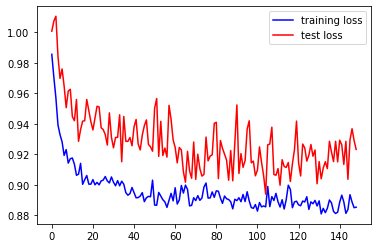

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_loss[1:150], "b", label="training loss")
plt.plot(test_loss[1:150], "r", label="test loss")

plt.legend();

In [13]:
b_x, b_y, prediction = plot_model_direct(cnn_submeso, criterion, loader_test, optimizer)

#plt.pcolor(b_y[0,0,:,:])
#plt.colorbar()

Training starts on device Quadro RTX 8000, number of samples 1
validation loss: 156.06931038515683


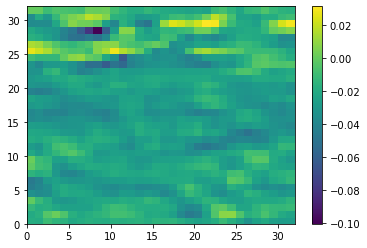

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.pcolor(cnn_submeso(b_x.to(device)).detach().cpu().numpy()[10,0,:,:])
plt.colorbar()

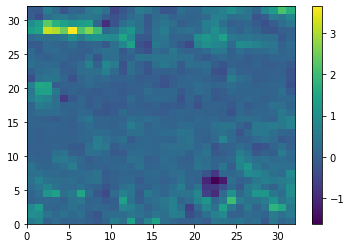

In [15]:
plt.pcolor(b_y[10,0,:,:])
plt.colorbar()

In [16]:
from scipy import stats
corr_pred = stats.pearsonr(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(), b_y.flatten())
#corr_pred = np.corrcoef(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(), b_y.flatten())
corr_pred

(0.375013947171248, 0.0)

In [ ]:
b_y.detach().cpu().shape

In [ ]:
cnn_submeso(b_x.to(device)).detach().cpu().numpy().shape

In [ ]:
_=plt.hist(b_y.detach().cpu().numpy().flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="target")
_=plt.hist(cnn_submeso(b_x.to(device)).detach().cpu().numpy().flatten(),bins=500,alpha=0.5,histtype='stepfilled',label="prediction")

plt.xlim([-3,3])
plt.legend()